<a href="https://colab.research.google.com/github/slz4025/twitter_latent_scams/blob/master/semi_supervised_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a semi-supervised classifier for identifying tweets that talk about scams. The workflow is inspired by Scam Detection in Twitter (2014): https://link.springer.com/chapter/10.1007/978-3-642-45252-9_9

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
file_name = "filtered_covid_20200602" #@param {type: "string"}

In [ ]:
processed_dir = "drive/My Drive/latent_scams/processed_data/"
analyzed_dir = "drive/My Drive/latent_scams/analyzed/"
data_file = "{}.tsv".format(file_name)
score_file = "scored_{}.tsv".format(file_name)
intermediate_file = "intermediate_{}.tsv".format(file_name)
labelled_file = "labelled_{}.tsv".format(file_name)
forest_params_file = "forest_params.json"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

##Preprocessing

In [ ]:
score_pd = pd.read_csv(analyzed_dir + score_file, sep="\t")
del score_pd["Unnamed: 0"]
score_pd.head()

In [ ]:
tweet_pd = pd.read_csv(processed_dir + data_file, sep="\t")
del tweet_pd["Unnamed: 0"]
tweet_pd.head()

In [ ]:
scored_tweets_pd = pd.merge(score_pd, tweet_pd, how="outer", on=["tweet_id"]).reset_index()
scored_tweets_pd.head()

###Cleaning data

In [ ]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize 
# from nltk.stem.porter import PorterStemmer
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'ag

In [ ]:
# taking out !#$@'?"&()*+-/:;<=>[\]^_`{|}~
modified_punc = """
.,
"""

Thesaurus is expensive, so do for top N (100, 200) tweets. 
~2000 words carry meaning of conversation. => Look at these and give to Prof. Carley.
Prof. Carley may have thesaurus that can process for these.
Also thesaurus for variations of COVID.
Thesaurus is only more important in actual analysis.


In [ ]:
# for each row, de-punctuate
# remove stop words
# don't de-stem for now as different stems have somewhat different associations
# de-emoji: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python

def de_emojify(text):
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regex_pattern.sub(r'', text)

#https://help.twitter.com/en/using-twitter/replies-not-showing-up-and-hashtag-problems
# (1) words with opt. apostrophe
# (2) words with opt. @ prefix
# (3) words with opt. # prefix
# (4) keep acronyms (i.e. U.S.A.)
# (5) punctuation treated as separate token
pattern = r"""(?:[A-Z]\.)+[A-Z]?|\w+(?:'\w+)*|@?\w+|#?\w+|[!$'?"&()*+-/:;<=>[\]^_`{|}~]"""

#https://www.nltk.org/book/ch03.html#sec-tokenization
def tweet_tokenize(text):
  return nltk.regexp_tokenize(text, pattern)

def clean_body(body):
  de_punc = body.translate(str.maketrans('', '', modified_punc))
  de_emoji = de_emojify(de_punc)
  tokens = tweet_tokenize(de_emoji) 
  de_stop = [word for word in tokens if word.lower() not in stopwords.words('english')]
  return de_stop

# test
print(tweet_tokenize("We'll see about that @missy #revenge"))
print(tweet_tokenize("!$'?\"&()*+-/:;<=>[]^_`{|}~#@"))
print(tweet_tokenize("U.S.A U.S.A. u.s.a u.s.a."))
print(clean_body("He @bud It's a long walk home😢 #tears."))

["We'll", 'see', 'about', 'that', '@missy', '#revenge']
['!', '$', "'", '?', '"', '&', '(', ')', '*', '+', '-', '/', ':', ';', '<', '=', '>', '[', ']', '^', '_', '`', '{', '|', '}', '~']
['U.S.A', 'U.S.A.', 'u', '.', 's', '.', 'a', 'u', '.', 's', '.', 'a', '.']
['@bud', 'long', 'walk', 'home', '#tears']


In [ ]:
cleaned = []
for i, row in scored_tweets_pd.iterrows():
  cleaned.append(clean_body(row["body"]))
  if i % 1000 == 0: print(i)

In [ ]:
scored_tweets_pd["cleaned"] = cleaned
clean_text = cleaned
detokenized_text = [' '.join(t) for t in clean_text]
scored_tweets_pd["cleaned_text"] = detokenized_text
len(detokenized_text)

392691

###Intermediate step

Save progress

In [ ]:
scored_tweets_pd.to_csv(sep='\t', path_or_buf=processed_dir + intermediate_file)
scored_tweets_pd.head()

Use progress

In [ ]:
# if already have file
scored_tweets_pd = pd.read_csv(processed_dir + intermediate_file, sep='\t')

###Optional thresholding by score

In [ ]:
pos_threshold = 3
good = scored_tweets_pd[scored_tweets_pd["score"] >= pos_threshold]
good.shape[0]

2064

In [ ]:
neg_threshold = 0
bad = scored_tweets_pd[scored_tweets_pd["score"] <= neg_threshold]
bad.shape

(378937, 8)

In [ ]:
bad = bad.sample(n=good.shape[0])
bad.shape

(2064, 8)

In [ ]:
scored_tweets_pd = pd.concat([good, bad])

In [ ]:
detokenized_text = scored_tweets_pd["cleaned_text"].tolist()
clean_text = [d.split(' ') for d in detokenized_text]
print(scored_tweets_pd.shape)
scored_tweets_pd.head()

##LSA

Still standard ways to map documents to semantic space. 
Word vector (word2vec) and use some clustering technique.
May try word2vec or another one.
Bert or other high-level transformer/attention-based models.

If want to cluster based on social AND semantic then use multi-modal, high-dimensional clustering (~Iain).

###ATTEMPT 1: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from gensim.models.coherencemodel import CoherenceModel

In [ ]:
dictionary = corpora.Dictionary(clean_text)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in clean_text]
len(doc_term_matrix), len(doc_term_matrix[0])

(4128, 31)

###Intermediate step

Save progress

In [ ]:
scored_tweets_pd["term_vec"] = scored_tweets_pd
scored_tweets_pd.to_csv(sep='\t', path_or_buf=processed_dir + "2_" + intermediate_file)

Use progress

In [ ]:
scored_tweets_pd = pd.read_csv(processed_dir + "2_" + intermediate_file, sep='\t')
clean_text = scored_tweets_pd["cleaned"].tolist()
detokenized_text = scored_tweets_pd["cleaned_text"].tolist()
doc_term_matrix = scored_tweets_pd["term_vec"].tolist()
scored_tweets_pd.head()

###Choose number of topics

In [ ]:
start,stop,step=2, 15, 1

coherence_values = []
for num_topics in range(start, stop, step):
    model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)
    coherencemodel = CoherenceModel(model=model, texts=clean_text, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

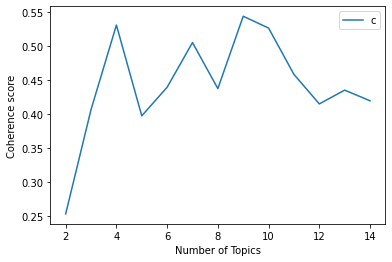

In [ ]:
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

###Perform

In [ ]:
number_of_topics = 9
lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
# look at topics
for t in lsamodel.print_topics(num_topics=number_of_topics):
  print(t)

def cluster_vec(tups):
  vec = [0.0 for i in range(number_of_topics)]
  for i,v in tups:
    vec[i] = v
  return np.array(vec)

X_topics = np.array([cluster_vec(e) for e in lsamodel[doc_term_matrix]])
X_topics.shape

###Intermediate Step

Save progress

In [ ]:
topic_list = X_topics.tolist()
scored_tweets_pd["topics"] = topic_list
scored_tweets_pd.to_csv(sep='\t',path_or_buf=processed_dir + +"3_" + intermediate_file)

Use Progress

In [ ]:
scored_tweets_pd = pd.read_csv(processed_dir + "3_" + intermediate_file, sep='\t')
clean_text = scored_tweets_pd["cleaned"].tolist()
detokenized_text = scored_tweets_pd["cleaned_text"].tolist()
doc_term_matrix = scored_tweets_pd["term_vec"].tolist()
X_topics = np.array(scored_tweets_pd["topics"])
scored_tweets_pd.head()

###ATTEMPT 2: https://medium.com/kuzok/news-documents-clustering-using-python-latent-semantic-analysis-b95c7b68861c

In [ ]:
"""
from sklearn.feature_extraction.text import TfidfVectorizer

# may want to change max_features, which is frequency
# may want to change max_df, which is frequency
vectorizer = TfidfVectorizer(
    #stop_words=stopwords,
    #max_features=10000,
    #max_df = 0.5,
    use_idf = True,
    ngram_range=(1,3)
  )
X = vectorizer.fit_transform(detokenized_text)
terms = vectorizer.get_feature_names()
X.shape

# LSA - we also condense the vectors

num_topics = 10
debug = False
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(X, n_components=num_topics, n_iter=100,
                              random_state=122)
#printing the concepts
for i, comp in enumerate(VT):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        if debug:
          print("Concept "+str(i)+": ")
          for t in sorted_terms:
              print(t[0])
          print(" ")

# get a condensed vector of each text
X_topics = U * Sigma
X_topics.shape
"""

(51, 2109)

### Visual analysis

In [ ]:
hard_topics = np.argmax(X_topics, axis=1)
hard_topics.shape

(4128,)

In [ ]:
# Create 2D embedding to judge how good the concepts are

import umap
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=12).fit_transform(X_topics)

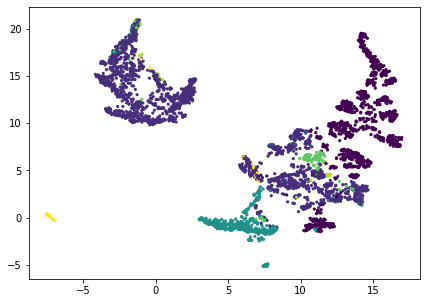

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1], 
    c = hard_topics,
    s = 10, # marker size
    edgecolor='none'
)
plt.show()

## K-Means

In [ ]:
# We use the reduced form.
X = X_topics

###Choose optimal K: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

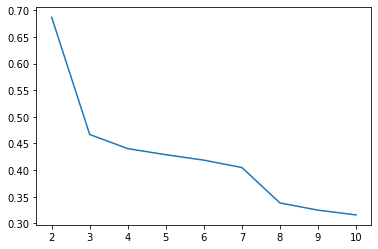

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
ks = [k for k in range(2, kmax + 1)]
for k in ks:
  kmeans = KMeans(n_clusters = k).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(ks, sil)

Choose optimum number based on graph above.

In [ ]:
# K-Means clustering with representative identification

num_clusters = 7 # probably same as num topics
km = KMeans(n_clusters=num_clusters)
km.fit(X)
clusters = km.labels_
centroids = km.cluster_centers_

### Intermediate Step

Save progress

In [ ]:
scored_tweets_pd["k_cluster"] = clusters
scored_tweets_pd.to_csv(sep='\t',path_or_buf=processed_dir + +"4_" + intermediate_file)

Use progress

In [ ]:
scored_tweets_pd = pd.read_csv(processed_dir + "4_" + intermediate_file, sep='\t')
clean_text = scored_tweets_pd["cleaned"].tolist()
detokenized_text = scored_tweets_pd["cleaned_text"].tolist()
doc_term_matrix = scored_tweets_pd["term_vec"].tolist()
X_topics = np.array(scored_tweets_pd["topics"].tolist())
clusters = scored_tweets_pd["k_cluster"].tolist()

X = X_topics

scored_tweets_pd.head()

###Examine representatives

In [ ]:
def find_rep(data, C, i_centroid, cluster_labels):
  D = data[cluster_labels == i_centroid]
  # index is 1D so take first dim
  I = np.where(cluster_labels == i_centroid)[0]
  min_ind = np.argmin([np.linalg.norm(C-d) for d in D])
  true_min_ind = I[min_ind]
  return true_min_ind

representatives = []
for i, C in enumerate(centroids):
    rep = find_rep(X, C, i, clusters)
    representatives.append(rep)
print(representatives)

[1243, 1165, 1132, 752, 2029, 732, 2468]


In [ ]:
# We manually classify the representatives
print('\t'.join(["cluster", "index", "text"]))

for i, r in enumerate(representatives):
  print('\t'.join([str(i), str(r), detokenized_text[r]]))

cluster	index	text
0	1243	studentreasures wallburner Looking forward internet technology got hit Ransomware ! We October March Coronavirus hit ! A normal school year would nice ! 🤣
1	1165	Google blocks 18 million Covid19 scams Gmail every day # Google # COVID19 # Gmail # Scam # Spam # Attack httpstcomt1bcIynQI
2	1132	Please # enjoy # todays # Privacy # Legion httpstcoRhjSLQxU1C # Protect # data # unauthorized # access unauthorized # acquisition # times ! # COVID19 # CoronaVirus # Threats # Risk # CyberSecurity # Law # IdentityThieves # ContactTracing # GDPR # Surveillance # Breach
3	752	It wont work It destroy tourism industry And Im talking big businesses Im talking independent tour operators dont cash reserves sitting refunds And government wont help listen
4	2029	NEWS Amid Pandemic Crypto Crime Surges First 5 Months CipherTrace httpstcoAtuXae0FJf # Cryptocurrency # Fraud # Coronavirus # Intelligence # DigitalCurrency # PaymentSystem # Planet # ChiefExecutiveOfficer # Reuters # Order

In [ ]:
train_indices = [1165, 1132, 752, 2029, 732, 2468]
train_labels = [1, 1, 0, 1, 1, 0]

###Make seed iteration of labelled data

In [ ]:
labelled = [-1 for i in range(len(detokenized_text))] # default all unlabelled
predictions = [np.nan for i in range(len(detokenized_text))]
for i, l in zip(train_indices, train_labels):
  predictions[i] = l
  labelled[i] = 0

In [ ]:
entries = []
for i, (x, t) in enumerate(zip(X, detokenized_text)):
  entries.append({"rep": x, "text": t})
entries_df = pd.DataFrame(entries, columns=["rep", "text"])
entries_df["labelled"] = labelled
entries_df["iteration_0_label"] = predictions
# no corresponding score for this

##Random forest classifier

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# look more into `apply`/`decision_path` to see which leaf each tweet ends up
# feature_importance_
# score

from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=0)

0.8078500000000001

###Get previous iteration of data

In [ ]:
entries_df = pd.read_csv(analyzed_dir + labelled_file)
with open(analyzed_dir + forest_param_file, 'r') as f:
    params = json.load(f)
rf.set_params(params)

###Training

In [ ]:
# get labelled data
labelled = entries_df[entries_df["labelled"] is not -1]
train_features = labelled["rep"].to_list()
train_labels = labelled["iteration_{}_label".format(iteration)]
iteration = 1 # for new round

In [ ]:
# train forest
rf = rf.fit(train_features, train_labels)
rf.score(train_features, train_labels) # R^2

In [ ]:
# get score for each entry
unlabelled = entries_df[entries_df["labelled"] == False]
prediction = []
scores = []
for i, row in unlabelled.iterrows():
  prediction.append(rf.predict(row["rep"]))
  scores.append(rf.score(row["rep"]))
unlabelled["iteration_{}_label".format(iteration)] = prediction
unlabelled["iteration_{}_score".format(iteration)] = scores
entries_df = pd.concat([unlabelled, entries_df], axis=1, sort=False))

In [ ]:
# hard label the top N points of each class
N = 50
for label, group in entries_df.groupby("label"):
  top = group.sort_values("iteration_{}_score".format(iteration)).head(N)
  top["labelled"] = iteration
  entries_df = pd.concat([top, entries_df], axis=1, sort=False))

###Save current iteration of data

In [ ]:
entries_df.to_csv(sep='\t', path_or_buf=analyzed_dir + labelled_file)
params = rf.get_params()
with open(forest_param_file, 'w') as f:
    json.dump(params, f)

If desired, the human can intervene here and analyze the output file. 
They can sort the data by labelled and view the newest iteration of labellings, then change it if needed.